<a href="https://colab.research.google.com/github/sachinkavindaa/Physics-Brain-Tumour-Segmentation-Project/blob/master/IOU1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Physics_Project/Brain/Healthcare AI Datasets/Brain_MRI

/content/drive/MyDrive/Physics_Project/Brain/Healthcare AI Datasets/Brain_MRI


In [31]:
IMAGE_SIZE = (256, 256)

In [5]:
brain_df = pd.read_csv('data_mask.csv')

In [6]:
brain_df.mask_path[1]
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [20]:
brain_df_train = brain_df.drop(columns = ['patient_id'])

In [21]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x : str(x))

In [65]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(brain_df_train, test_size=0.15)
df_train, df_val = train_test_split(brain_df_train, test_size=0.15)

In [66]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)

In [67]:
train_generator=datagen.flow_from_dataframe(
dataframe = df_train,
directory='./', x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='training'
)

valid_generator=datagen.flow_from_dataframe(
dataframe = df_val,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./225., validation_split=0.15)

test_generator=datagen.flow_from_dataframe(
dataframe = df_test,
directory='./', 
x_col='image_path', 
y_col='mask', 
target_size=(256, 256), 
class_mode='categorical', 
batch_size=32, 
shuffle=True,  
)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 16 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2825 validated image filenames belonging to 2 classes.
Found 87 validated image filenames belonging to 2 classes.
Found 587 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [68]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

clf_model = Model(base_model.input, outputs=x)
clf_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
clf_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [69]:
import seaborn as sns
preds = clf_model.predict(test_generator)
preds = np.argmax(preds, axis=1)
labels = np.asarray(test['mask']).astype('int')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(labels, preds)
print("Accuracy: {:.3f}".format(accuracy*100))

cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, labels=[0,1])
print(report)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)

ValueError: ignored

In [70]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)


def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [71]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [72]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])



In [76]:
EPOCHS = 10
BATCH_SIZE = 16
learning_rate = 1e-4

In [77]:

from tensorflow.python.keras import optimizers as opt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [78]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 16 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3323 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 16 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3323 validated image filenames.
Epoch 1/10
209/208 [==============================] - ETA: -1s - loss: -0.1117 - binary_accuracy: 0.9316 - iou: 0.0606 - dice_coef: 0.1117Found 586 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 586 validated image filenames.
208/208 [==============================] - 1399s 7s/step - loss: -0.1117 - binary_accuracy: 0.9316 - iou: 0.0606 - dice_coef: 0.1117 - val_loss: -0.0725 - val_binary_accuracy: 0.8685 - val_iou: 0.0384 - val_dice_coef: 0.0732

Epoch 00001: val_loss improved from inf to -0.07252, saving model to unet_brainMRI_seg.hdf5
Epoch 2/10
208/208 [==============================] - 335s 2s/step - loss: -0.1908 - binary_accuracy: 0.9835 - iou: 0.1081 - dice_coef: 0.1907 - val_loss: -0.1151 - val_binary_accuracy: 0.9090 - val_iou: 0.0621 - val_dice_coef: 0.1153

Epoch 00002: val_loss improved from -0.07252 to -0.11506, saving model to unet_brainMRI_seg.hdf5
Epoch 3/10
208/208 [==============================] - 335s 2s/step - loss: -0.2857 - binary_accuracy: 0.9900 - iou: 0.1721 - dice_coef: 0.2861 - val_loss: -0.3268 - val_binary_accuracy: 0.9894 - val_iou: 0.2052 - val_dice_coef: 0.3283

Epoch 00003: val_loss improved from -0.11506 to -0.32681, saving model to un

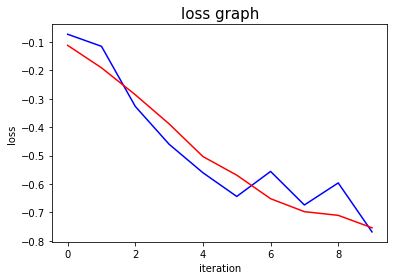

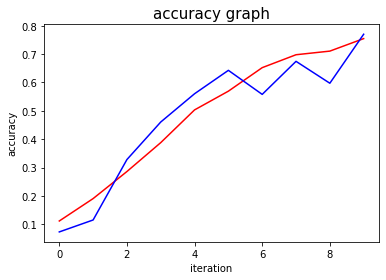

In [79]:
traindice = history.history['dice_coef']
testdice = history.history['val_dice_coef']

trainjaccard = history.history['iou']
testjaccard = history.history['val_iou']

trainloss = history.history['loss']
testloss = history.history['val_loss']
plt.figure(1)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [80]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 587 validated image filenames.
Found 587 validated image filenames.
36/36 [==============================] - 18s 475ms/step - loss: -0.7511 - binary_accuracy: 0.9963 - iou: 0.6250 - dice_coef: 0.7504
Test lost:  -0.7510629892349243
Test IOU:  0.9963265657424927
Test Dice Coefficent:  0.6249691247940063


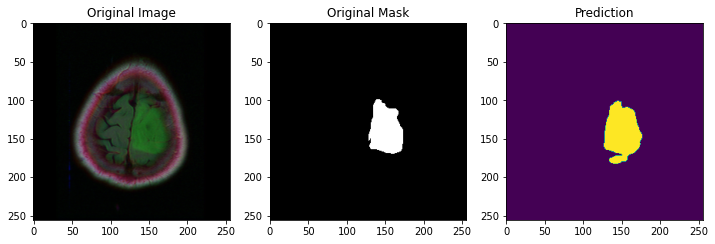

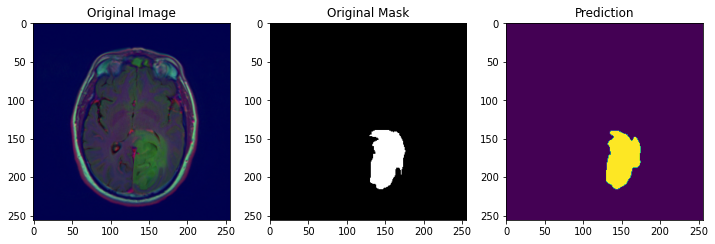

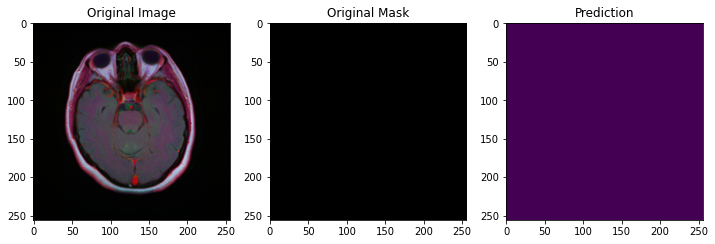

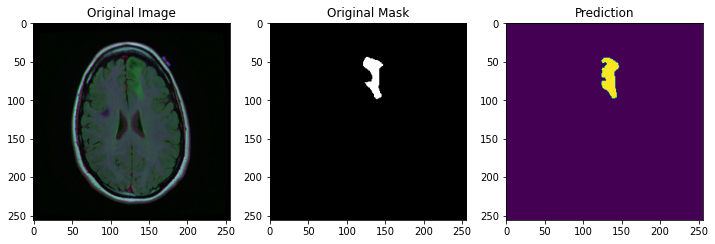

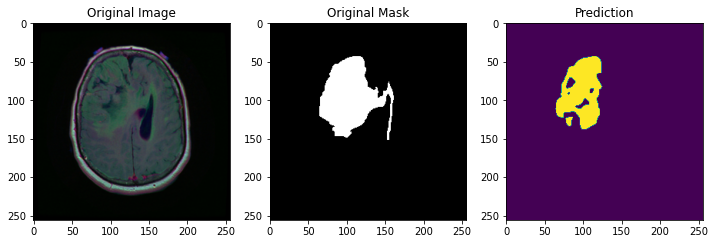

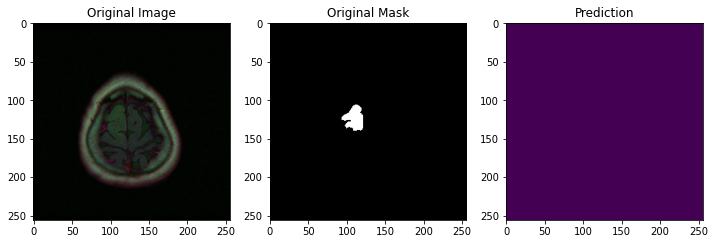

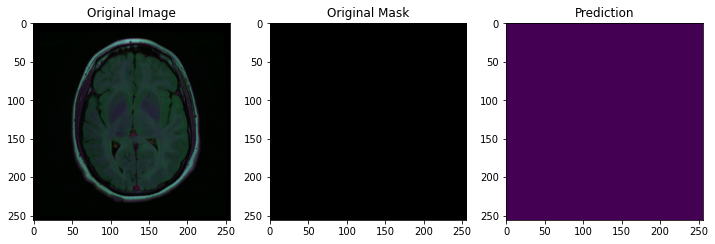

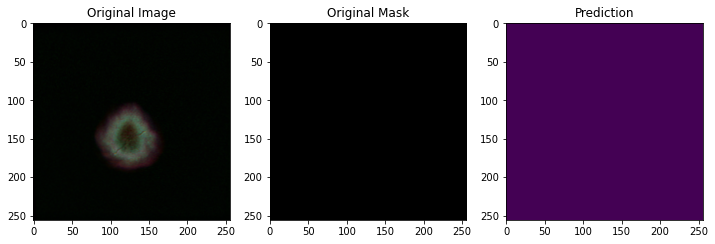

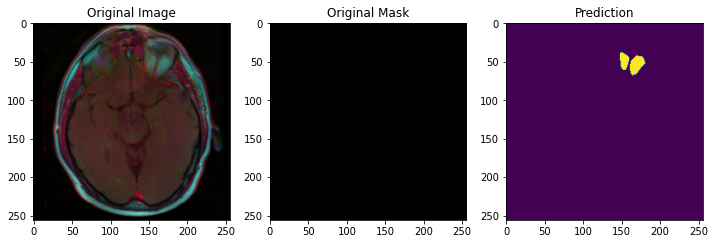

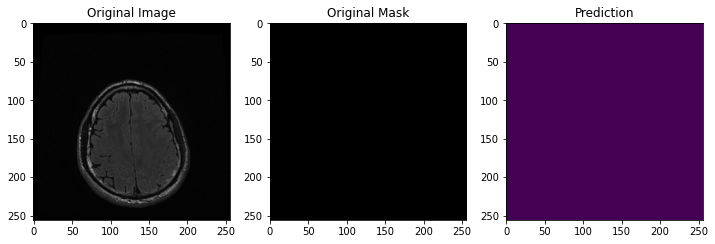

In [81]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()